In [1]:
import loading
import process_aravec
from gensim.models import Word2Vec
import os
import numpy as np
from keras.preprocessing.text import Tokenizer
from keras.models import Sequential
from keras import layers
from keras.optimizers import RMSprop
from keras.layers import Embedding, Conv1D,MaxPooling1D, Dense,Dropout,LSTM
from keras.callbacks import EarlyStopping
from sklearn import metrics
import matplotlib.pyplot as plt
import seaborn as sns             



/Users/xabuka/anaconda3/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [17]:
max_features = 10000
max_len = 100
training_samples = 11759  # We will be training on 200 samples
validation_samples = 2000  # We will be validating on 10000 samples
# Convolution
kernel_size = 5
filters = 64
pool_size = 2

# LSTM
lstm_output_size = 70
#keras model
epochs = 100
batch_size=128

#data directory
data_dir = '../data/SplitedPalSent'#SplitedPalSent'
saved_model = 'pre_trained_aravec_model.h5'


In [4]:
input_train, y_train = loading.load_train(data_dir,max_len,training_samples,validation_samples,max_features, Validation = False )
input_test, y_test = loading.load_test(data_dir,max_len,max_features)

Found 4276 unique tokens.
Shape of data tensor: (929, 100)
Shape of label tensor: (929,)


In [10]:
def embedding_matrix(data_dir,max_len,max_features):
    ara_dir = '../data/tweet_cbow_300/'
    word_index = loading.word_index(data_dir,max_len,max_features)
    t_model = Word2Vec.load(os.path.join(ara_dir,'tweets_cbow_300'))

    print('Found %s word vectors.' % len(t_model.wv.index2word))# how many words in aravec this model
    embeddings_index = t_model.wv

    embedding_dim = embeddings_index.vector_size #300
    embedding_matrix = np.zeros((max_features, embedding_dim))

    for word, i in word_index.items():
        word = process_aravec.clean_str(word).replace(" ", "_")
        if word in embeddings_index:
            embedding_vector = embeddings_index[word]
            if i < max_features:
                if embedding_vector is not None:
                    # Words not found in embedding index will be all-zeros.
                    embedding_matrix[i] = embedding_vector
                    #print(len(embedding_vector))
    return  embedding_matrix    

In [11]:
embedding_matrix = embedding_matrix(data_dir,max_len,max_features)

Found 331679 word vectors.


In [12]:
#building model CNN + LSTM
model = Sequential()
model.add(Embedding(max_features, 300,weights=[embedding_matrix], trainable=False, input_length=max_len))
model.add(Dropout(0.25))
model.add(Conv1D(filters, kernel_size, padding='valid', activation='relu', strides=1))
model.add(MaxPooling1D(pool_size=pool_size))
model.add(LSTM(lstm_output_size))
model.add(Dense(3,activation='sigmoid'))
print(model.summary())   

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 100, 300)          3000000   
_________________________________________________________________
dropout_1 (Dropout)          (None, 100, 300)          0         
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 96, 64)            96064     
_________________________________________________________________
max_pooling1d_1 (MaxPooling1 (None, 48, 64)            0         
_________________________________________________________________
lstm_1 (LSTM)                (None, 70)                37800     
_________________________________________________________________
dense_1 (Dense)              (None, 3)                 213       
Total params: 3,134,077
Trainable params: 134,077
Non-trainable params: 3,000,000
____________________________________________________________

In [ ]:
model.compile(loss = 'categorical_crossentropy', optimizer='rmsprop',metrics = ['accuracy'])
history = model.fit(input_train, y_train,
                    epochs=epochs,
                    batch_size=batch_size,
                    validation_split= 0.1)


model.save_weights(saved_model)   

Train on 836 samples, validate on 93 samples
Epoch 1/100
836/836 [==============================] - 2s 3ms/step - loss: 0.7984 - acc: 0.6328 - val_loss: 0.8943 - val_acc: 0.6237
Epoch 2/100
836/836 [==============================] - 2s 2ms/step - loss: 0.7047 - acc: 0.6639 - val_loss: 0.9493 - val_acc: 0.5806
Epoch 3/100
836/836 [==============================] - 2s 2ms/step - loss: 0.6354 - acc: 0.7129 - val_loss: 0.8826 - val_acc: 0.5914
Epoch 4/100
836/836 [==============================] - 2s 2ms/step - loss: 0.4971 - acc: 0.8146 - val_loss: 1.1636 - val_acc: 0.4731
Epoch 5/100
836/836 [==============================] - 2s 2ms/step - loss: 0.5045 - acc: 0.7787 - val_loss: 0.9016 - val_acc: 0.6129
Epoch 6/100
836/836 [==============================] - 2s 2ms/step - loss: 0.4229 - acc: 0.8481 - val_loss: 0.9924 - val_acc: 0.5269
Epoch 7/100
836/836 [==============================] - 2s 2ms/step - loss: 0.3637 - acc: 0.8684 - val_loss: 0.9367 - val_acc: 0.5699
Epoch 8/100
836/836 [===

# 'Testing And Evalaution'
1- classification report

In [14]:
#test and Evaluation
model.load_weights(saved_model)
predicted = model.predict(input_test, verbose = 2, batch_size = batch_size)
print(metrics.classification_report(y_test.argmax(axis=1), predicted.argmax(axis=1)))


              precision    recall  f1-score   support

           0       0.00      0.00      0.00        85
           1       0.58      1.00      0.73       150
           2       0.00      0.00      0.00        24

   micro avg       0.58      0.58      0.58       259
   macro avg       0.19      0.33      0.24       259
weighted avg       0.34      0.58      0.42       259



/Users/xabuka/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/Users/xabuka/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/Users/xabuka/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


2. Accuracy and Confuisn matrix

In [15]:
#predicted = np.argmax(predicted, axis=1)
metrics.accuracy_score(y_test.argmax(axis=1), predicted.argmax(axis=1))
print(metrics.accuracy_score(y_test.argmax(axis=1), predicted.argmax(axis=1)))
scores= model.evaluate(input_test, y_test,verbose=0)
print("Accuracy: %.2f%%" % (scores[1]*100))

conf_mat = metrics.confusion_matrix(y_test.argmax(axis=1), predicted.argmax(axis=1))
print(conf_mat)

0.5791505791505791
Accuracy: 57.92%
[[  0  85   0]
 [  0 150   0]
 [  0  24   0]]


3. Plot

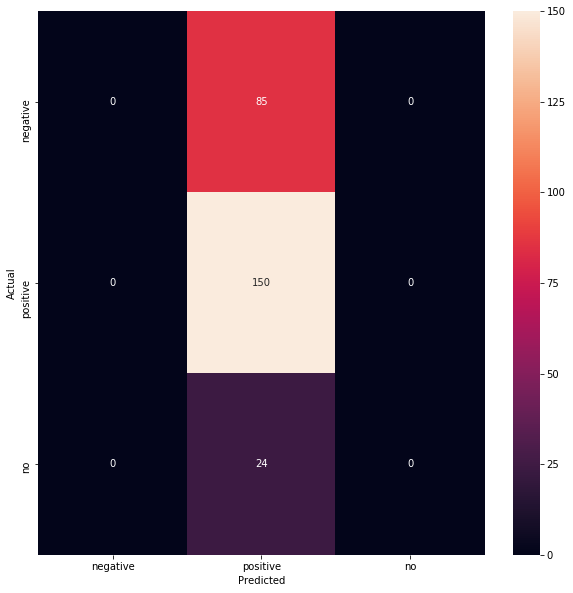

In [16]:
fig, ax = plt.subplots(figsize=(10,10))
sns.heatmap(conf_mat, annot=True, fmt='d',
            xticklabels=['negative','positive','no'], yticklabels=['negative','positive','no'])
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.show()